In [13]:
import pandas as pd
import pymongo
import requests
from bs4 import BeautifulSoup
import time
import json
from collections import Counter


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split, cross_val_score

In [4]:
mc = pymongo.MongoClient()  # Connect to the MongoDB server using default settings
db = mc['chess_predictions']  # Use (or create) a database called 'chess_predictions'
players = db['players']  # Use (or create) a collection called 'players'

In [8]:
def get_player_profile(username):
    try:
        response = requests.get(f'https://api.chess.com/pub/player/{username}')
        return json.loads(response.content.decode('utf-8'))
    except:
        return [] 
        
def get_player_stats(username):
    try:
        response = requests.get(f'https://api.chess.com/pub/player/{username}/stats')
        return json.loads(response.content.decode('utf-8'))
    except:
        return []
        
def get_player_games(username):
    '''return a list of lists where each list contains the games played for each month January through May 2018'''
    
    months = ['01', '02', '03', '04', '05']
    month_games = []
    for month in months:
        try:
            response = requests.get(f'https://api.chess.com/pub/player/{username}/games/2018/{month}')
            month_games.append([json.loads(response.content.decode('utf-8'))])
        except:
            continue
    return month_games

def player_data_to_mongoDB(username, mongoDB_connection, database, collection):
    
    mc = mongoDB_connection
    
    #use/create a database
    db = mc[database]
    
    #use/create a collection
    collection = db[collection]
    
    #query Chess.com api for data
    profile = get_player_profile(username)
    stats = get_player_stats(username)
    games = get_player_games(username)
    
    #insert player data into database
    collection.insert_one({**profile,
                           **stats,
                           'games': games
                            })

def all_player_data_to_mongoDB(players, mongoDB_connection, database, collection, verbose=False):
    '''insert all player data into a mongoDB
       Params:
          players: list of player names
          mongoDB_connection: open connection to database ex. pymongo.MongoClient()
          database: name of database
          collection: name of collection
       Keyword Args:
          verbose: if True print player name after each insert, default is False
    '''
    for player in players:
        player_data_to_mongoDB(player, mongoDB_connection, database, collection)
        if verbose:
            print(player)

In [9]:
df_test = pd.DataFrame(list(db['players_testrun2'].find()))
df_test

,@id,_id,avatar,chess960_daily,chess_blitz,chess_bullet,chess_daily,chess_rapid,country,followers,games,joined,last_online,location,name,player_id,status,title,url,username
0,https://api.chess.com/pub/player/thefivekeyz,5afcd17009838819f5139363,https://images.chesscomfiles.com/uploads/v1/us...,NaN,"{'last': {'rating': 604, 'date': 1526489774, '...","{'last': {'rating': 421, 'date': 1526490678, '...",NaN,"{'last': {'rating': 679, 'date': 1526427171, '...",https://api.chess.com/pub/country/US,1,[[{'games': [{'url': 'https://www.chess.com/li...,1516930743,1526490750,Florida,Carlos Vega,42689010,basic,NaN,https://www.chess.com/member/TheFiveKeyz,thefivekeyz
1,https://api.chess.com/pub/player/mr_shenanigans,5afcd17209838819f5139364,NaN,"{'last': {'rating': 1327, 'date': 1526168526, ...",NaN,NaN,"{'last': {'rating': 1299, 'date': 1525992145, ...",NaN,https://api.chess.com/pub/country/US,1,"[[{'games': []}], [{'games': [{'url': 'https:/...",1516498401,1526505845,NaN,Steve Reed,42523714,basic,NaN,https://www.chess.com/member/Mr_Shenanigans,mr_shenanigans
2,https://api.chess.com/pub/player/ljh815,5afcd18109838819f5139365,https://images.chesscomfiles.com/uploads/v1/us...,NaN,NaN,NaN,NaN,"{'last': {'rating': 1033, 'date': 1516329803, ...",https://api.chess.com/pub/country/US,0,[[{'games': [{'url': 'https://www.chess.com/li...,1515274701,1526482790,NaN,NaN,42070022,basic,NaN,https://www.chess.com/member/Ljh815,ljh815
3,https://api.chess.com/pub/player/pvallak,5afcd18609838819f5139366,NaN,NaN,"{'last': {'rating': 1176, 'date': 1526517161, ...",NaN,NaN,NaN,https://api.chess.com/pub/country/US,0,[[{'games': [{'url': 'https://www.chess.com/li...,1515843901,1526516069,NaN,NaN,42279642,basic,NaN,https://www.chess.com/member/pvallak,pvallak
4,https://api.chess.com/pub/player/psterpe,5afcd18809838819f5139367,https://images.chesscomfiles.com/uploads/v1/us...,NaN,"{'last': {'rating': 1101, 'date': 1518996892, ...",NaN,"{'last': {'rating': 1372, 'date': 1526323509, ...",NaN,https://api.chess.com/pub/country/US,1,[[{'games': [{'url': 'https://www.chess.com/da...,1515205727,1526513547,Missouri,NaN,42043608,premium,NaN,https://www.chess.com/member/psterpe,psterpe
5,https://api.chess.com/pub/player/anilcharu,5afcd19409838819f5139368,NaN,NaN,"{'last': {'rating': 1194, 'date': 1526509374, ...",NaN,"{'last': {'rating': 832, 'date': 1520729412, '...","{'last': {'rating': 1102, 'date': 1519760981, ...",https://api.chess.com/pub/country/US,5,[[{'games': [{'url': 'https://www.chess.com/da...,1516740826,1526508350,NaN,NaN,42613910,basic,NaN,https://www.chess.com/member/anilcharu,anilcharu
6,https://api.chess.com/pub/player/mrschessmate,5afcd1a109838819f5139369,NaN,NaN,"{'last': {'rating': 565, 'date': 1519494122, '...","{'last': {'rating': 1065, 'date': 1516516235, ...",NaN,NaN,https://api.chess.com/pub/country/US,0,[[{'games': [{'url': 'https://www.chess.com/li...,1514873292,1526440945,NaN,NaN,41916442,basic,NaN,https://www.chess.com/member/MrsChessmate,mrschessmate
7,https://api.chess.com/pub/player/ishagr,5afcd1a509838819f513936a,NaN,NaN,"{'last': {'rating': 1125, 'date': 1526442161, ...","{'last': {'rating': 844, 'date': 1526346371, '...",NaN,"{'last': {'rating': 1187, 'date': 1522869629, ...",https://api.chess.com/pub/country/US,0,[[{'games': [{'url': 'https://www.chess.com/li...,1515282066,1526443085,NaN,NaN,42072928,basic,NaN,https://www.chess.com/member/ishagr,ishagr
8,https://api.chess.com/pub/player/shimmo123,5afcd1aa09838819f513936b,NaN,NaN,"{'last': {'rating': 1109, 'date': 1526442023, ...","{'last': {'rating': 856, 'date': 1516214357, '...",NaN,"{'last': {'rating': 1162, 'date': 1520691906, ...",https://api.chess.com/pub/country/US,0,[[{'games': [{'url': 'https://www.chess.com/li...,1516213228,1526437624,NaN,NaN,42415610,basic,NaN,https://www.chess.com/member/Shimmo123,shimmo123
9,https://api.chess.com/pub/player/ginagwen,5afcd1ae09838819f513936c,https://images.chesscomfiles.com/uploads/v1/us...,NaN,NaN,NaN,"{'last': {'rating': 1062, 'date': 151828

In [217]:
df_test.joined.max()

1517442624

In [218]:
mc = pymongo.MongoClient()  # Connect to the MongoDB server using default settings
db = mc['chess_predictions']  # Use (or create) a database called 'chess_predictions'

#get data from mongoDB and put into dataframe
df = pd.DataFrame(list(db['players_testrun'].find()))

print('done importing from mongoDB')

#remove duplicate users by player_id
df.drop_duplicates(subset='player_id', inplace=True)

#reset the index
df.reset_index(drop=True, inplace=True)

print('now making X and y')

#create features and target
X, y = make_X_and_y(df)

#make a train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

random_forest_testrun = RandomForestClassifier()
random_forest_testrun.fit(X_train, y_train)
y_predict = random_forest_testrun.predict_proba(X_test)

print(roc_auc_score(y_test, y_predict[:, 1]))

print('all done my dude!')

done importing from mongoDB
now making X and y
all done my dude!


In [14]:
random_forest_testrun = RandomForestClassifier()
random_forest_testrun.fit(X_train, y_train)
y_predict = random_forest_testrun.predict_proba(X_test)

print(roc_auc_score(y_test, y_predict[:, 1]))

NameError: name 'X_train' is not defined

In [221]:
X_train.iloc[:, :10].columns

Index(['followers', 'joined', 'A00', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06',
       'A07'],
      dtype='object')

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split, cross_val_score

random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
y_predict = random_forest.predict_proba(X_test)

roc_auc_score(y_test, y_predict[:, 1])

cross_val_score(random_forest, X_test, y_test, cv=20)

NameError: name 'X_train' is not defined

In [49]:
def plot_roc(model, x_columns, y_true):

    y_pred = model.predict_proba(x_columns)

    fpr, tpr, threshold = roc_curve(y_true, y_pred[:,1])
    area_under_curve = auc(fpr, tpr)

    # method I: plt
    fig, ax = plt.subplots()
    model_name = str(type(model)).split('.')[-1].strip(">\'")
    plt.title(f'{model_name} ROC')
    ax.plot(fpr, tpr, 'k', label = 'C AUC = %0.3f' % area_under_curve)

    ax.legend(loc = 'lower right')
    ax.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [10]:
random_forest_rated = RandomForestClassifier()
random_forest_rated.fit(X_train[['has_name',
       'has_location', 'has_avatar', 'is_basic', 'is_premium', 'chess']], y_train)
plot_roc(random_forest_rated, X_test[['has_name',
       'has_location', 'has_avatar', 'is_basic', 'is_premium', 'chess']], y_test)

NameError: name 'RandomForestClassifier' is not defined

values, features = rf_best_features(X_test[['has_name',
       'has_location', 'has_avatar', 'is_basic', 'is_premium']], y_test, 5)
plot_best_features(values, features)

In [46]:
def rf_best_features(X, y, n_features):
    
    x_columns = X

    y_true = y

    rf_model = RandomForestClassifier(n_estimators=100)
    
    rf_model.fit(x_columns, y_true)
    
    feature_importances = {}
    
    for i in range(len(rf_model.feature_importances_)):
        
        feature_importances[x_columns.columns[i]] = rf_model.feature_importances_[i]
    
    
    top_features = Counter(feature_importances).most_common(n_features)
    
    values = [feature[1] for feature in top_features]
    
    features = [feature[0] for feature in top_features]
    
    return values, features


def plot_best_features(values, features, figsize_x=10, figsize_y=10):
    
    new_df = pd.DataFrame(list(zip(values,features))).set_index(1).sort_values(0)

    new_df.plot.barh(figsize=(figsize_x,figsize_y))

# values, features = rf_best_features(X_test[['rated', 'D00']], y_test, 26)
# plot_best_features(values, features)

In [44]:
def games_in_a_month(games_column, player, month):
    return len(games_column[player][month][0]['games'])
    
def rated_games(games_column, player, month, game):
    return str(games_column[player][month][0]['games'][game]['rated'])

def time_class_games(games_column, player, month, game):
    return games_column[player][month][0]['games'][game]['time_class']

def rules_games(games_column, player, month, game):
    return games_column[player][month][0]['games'][game]['rules']

def eco_games(games_column, player, month, game):
    return games_column[player][month][0]['games'][game]['eco'][31:].split('-')[0]

def results_games(games_column, player, month, game):
    if games_column[player][month][0]['games'][game]['white'] == df.username[0]:
        return games_column[player][month][0]['games'][game]['white']['result']
    else:
        return games_column[player][month][0]['games'][game]['black']['result']

def make_columns(features, df, index):
    '''Counts the appearances of each type of outcome then creates a column in the dataframe corresponding to
    that outcome and filling in the number of occurrences for each player
    Params:
        features: List of each outcome ex: [c, a, a, d, d, a, d, c, j]
        df: pandas dataframe
        index: index to located each player
    '''
    counters = Counter()
    for feature in features:
        counters[feature] += 1

    for counter in counters:
        df.loc[index, counter] = counters[counter]


def parse_games(df, column='games', verbose=False):
    '''Pull out stats from the column containing games and add columns to the datafram inplace for the stats
    Params:
        df: pandas dataframe
    Keyword Args:
        column: column containing games, default column name is 'games'
        verbose: if True, print player indices as they are parsed, default is False
    '''
    games_column = df[column]
    player_idx = range(df.shape[0])
    for player in player_idx:
        if verbose:
            print(player)
        rated = []
        time_class = []
        rules = []
        eco = []
        results = []
        if len(games_column[player]) != 5:
            continue
        else:
            for month in range(4):
                try:
                    for game in range(games_in_a_month(games_column, player, month)):
                        try:
                            rated.append(rated_games(games_column, player, month, game))
                        except KeyError:
                            continue
                        try:
                            time_class.append(time_class_games(games_column, player, month, game))
                        except KeyError:
                            continue
                        try:
                            rules.append(rules_games(games_column, player, month, game))
                        except KeyError:
                            continue
                        try:
                            eco.append(eco_games(games_column, player, month, game))
                        except KeyError:
                            continue
                        try:
                            results.append(results_games(games_column, player, month, game))
                        except KeyError:
                            continue
                except KeyError:
                    continue
                    
            df.loc[player, 'may_games'] = games_in_a_month(games_column, player, 4)
            
            make_columns(time_class, df, player)
            make_columns(rated, df, player)
            make_columns(rules, df, player)
            make_columns(eco, df, player)
            make_columns(results, df, player)
            
def init_columns(df):
    '''Add columns for all eco codes, rated games, time_class, rules
    Params:
        df: pandas dataframe
    '''
    labels = ['win', 'checkmated', 'agreed', 'repetition', 'timeout', 'resigned', 
               'stalemate', 'lose', 'insufficient', '50move', 'abandoned', 'kingofthehill',
               'threecheck', 'timevsinsufficient', 'bughousepartnerlose', 'False', 'True',
               'standard', 'daily', 'blitz', 'lightning', 'chess960', 'crazyhouse', 'bughouse', 'chess']
    for label in labels:
        df[label] = 0
        
def make_X_and_y(df):
    '''make all feature columns and target column
    Params:
        df: pandas datafram
    Returns:
        X: all important feature columns
        y: target column, 1 (inactive: less than 2 games played during the last month) or 0 (active)
    '''
    #initialize columns
    init_columns(df)

    #parse games column
    parse_games(df)
    
    #rename True and False columns to rated and unrated
    df.rename(columns={'True': 'rated', 'False': 'unrated'}, inplace=True)

    #create inactive column (1 = inactive, 0 = active) inactive if they have not played a game in two weeks (may 1st)
    def is_inactive(x):
        '''checks if value is less than 2
        '''
        if x < 2:
            return 1
        else:
            return 0

    df['inactive'] = df['may_games'].apply(lambda x: is_inactive(x))

    #create columns has_name, has_location, has_avatar
    def has_attribute(x):
        if x != x:
            return 0
        else:
            return 1

    df['has_name'] = df['name'].apply(lambda x: has_attribute(x))
    df['has_location'] = df['location'].apply(lambda x: has_attribute(x))
    df['has_avatar'] = df['avatar'].apply(lambda x: has_attribute(x))

    #make a basic account type column
    def is_basic(x):
        '''check if value is the string basic'''
        if x == 'basic':
            return 1
        else:
            return 0

    df['is_basic'] = df['status'].apply(lambda x: is_basic(x))

    #make a premium account type column
    def is_premium(x):
        '''check if value is the string premium'''
        if x == 'premium':
            return 1
        else:
            return 0

    df['is_premium'] = df['status'].apply(lambda x: is_premium(x))
    
    #assign X and y variables
    y = df['inactive']
    
    X = df.drop(columns=['@id', '_id', 'avatar', 'chess960_daily', 'chess_blitz',
                         'chess_bullet', 'chess_daily', 'chess_rapid', 'country',
                         'games', 'last_online', 'location', 'name', 'player_id',
                         'status', 'url', 'username', 'may_games', 'inactive', 'title'])
    
    return (X, y)

In [113]:
df

,rated,unrated
0,33,0
1,823,830
2,0,0
3,6,0
4,285,114


In [135]:
df.drop(labels=['standard', 'daily', 'blitz', 'lightning'],axis=1, inplace=True)

In [137]:
df.drop(labels=['True', 'False'],axis=1, inplace=True)

In [ ]:
df['games'][player][month][0]['games'][one game from the month]['url',
                                                                'pgn',
                                                                'time_control',
                                                                'end_time',
                                                                'rated',
                                                                'fen',
                                                                'time_class',
                                                                'rules',
                                                                'white',
                                                                'black']


In [232]:
letters = ['A', 'B', 'C', 'D', 'E']
nums = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
eco_codes = []
for letter in letters:
    for num in nums:
        for num2 in nums:
            eco_codes.append(letter + num + num2)
print(eco_codes)

['A00', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36', 'A37', 'A38', 'A39', 'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48', 'A49', 'A50', 'A51', 'A52', 'A53', 'A54', 'A55', 'A56', 'A57', 'A58', 'A59', 'A60', 'A61', 'A62', 'A63', 'A64', 'A65', 'A66', 'A67', 'A68', 'A69', 'A70', 'A71', 'A72', 'A73', 'A74', 'A75', 'A76', 'A77', 'A78', 'A79', 'A80', 'A81', 'A82', 'A83', 'A84', 'A85', 'A86', 'A87', 'A88', 'A89', 'A90', 'A91', 'A92', 'A93', 'A94', 'A95', 'A96', 'A97', 'A98', 'A99', 'B00', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'B17', 'B18', 'B19', 'B20', 'B21', 'B22', 'B23', 'B24', 'B25', 'B26', 'B27', 'B28', 'B29', 'B30', 'B31', 'B32', 'B33', 'B34', 'B35', 'B36', 'B37', 'B38', 'B39', 'B40', 'B41', 'B42'

In [28]:
df_2017 = pd.DataFrame(list(db['test'].find()))
df_2017.shape

(2169, 20)

In [45]:
mc = pymongo.MongoClient()  # Connect to the MongoDB server using default settings
db = mc['chess_predictions']  # Use (or create) a database called 'chess_predictions'

#get data from mongoDB and put into dataframe
df = df_2017

# print('done importing from mongoDB')

#remove duplicate users by player_id
df.drop_duplicates(subset='player_id', inplace=True)

#reset the index
df.reset_index(drop=True, inplace=True)

print('now making X and y')

#create features and target
X, y = make_X_and_y(df)

#make a train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

random_forest_testrun = RandomForestClassifier()
random_forest_testrun.fit(X_train, y_train)
y_predict = random_forest_testrun.predict_proba(X_test)

print(roc_auc_score(y_test, y_predict[:, 1]))

print('all done my dude!')

now making X and y
0.8768654224952426
all done my dude!


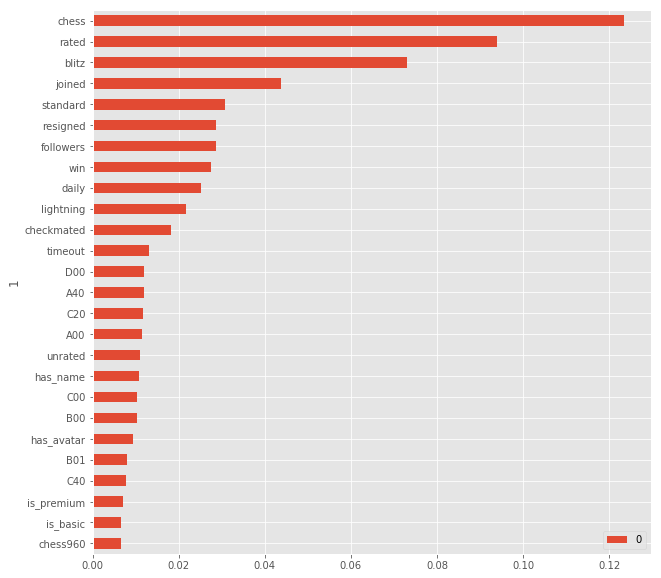

In [47]:
values, features = rf_best_features(X_test[['']], y_test, 26)
plot_best_features(values, features)

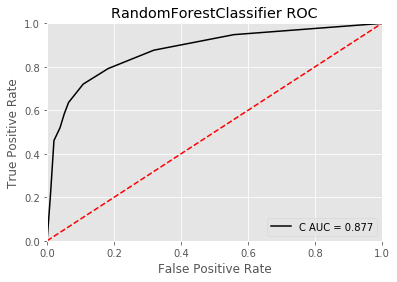

In [56]:
plot_roc(random_forest_testrun, X_test, y_test)